In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import StackingRegressor

In [2]:
# Load Data - Train Data
Train_Data=(pd.read_csv('train_cab.csv', header = 0 )).drop(columns="pickup_datetime")

In [3]:
Train_Data.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0


In [4]:
Train_Data.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,16067.000000,16067.000000,16067.000000,16067.000000,16012.000000
mean,-72.462787,39.914725,-72.462328,39.897906,2.625070
std,10.578384,6.826587,10.575062,6.187087,60.844122
min,-74.438233,-74.006893,-74.429332,-74.006377,0.000000
25%,-73.992156,40.734927,-73.991182,40.734651,1.000000
50%,-73.981698,40.752603,-73.980172,40.753567,1.000000
75%,-73.966838,40.767381,-73.963643,40.768013,2.000000
max,40.766125,401.083332,40.802437,41.366138,5345.000000


In [5]:
print("old size: %d" % len(Train_Data))
Train_Data = Train_Data.dropna(how='any', axis=0)
print("New size after dropping missing value: %d" % len(Train_Data))

old size: 16067
New size after dropping missing value: 15988


In [6]:
Train_Data['fare_amount']= Train_Data['fare_amount'].apply(pd.to_numeric, errors='coerce')
Train_Data['fare_amount']= Train_Data['fare_amount'].replace({0:np.nan})
Train_Data['passenger_count']=Train_Data['passenger_count'].fillna(0)
Train_Data['passenger_count']= Train_Data['passenger_count'].astype(int)
Train_Data['passenger_count']=Train_Data['passenger_count'].replace({0: np.nan})
Train_Data['pickup_longitude']= Train_Data['pickup_longitude'].replace({0:np.nan})
Train_Data['pickup_latitude']= Train_Data['pickup_latitude'].replace({0:np.nan})
Train_Data['dropoff_longitude']= Train_Data['dropoff_longitude'].replace({0:np.nan})
Train_Data['dropoff_latitude']= Train_Data['dropoff_latitude'].replace({0:np.nan})

In [7]:
Train_Data.shape

(15988, 6)

In [8]:
Train_Data.dtypes

fare_amount          float64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      float64
dtype: object

In [9]:
# Missing values Treatment.

In [10]:
Train_Data.isnull().sum()

fare_amount            2
pickup_longitude     313
pickup_latitude      313
dropoff_longitude    312
dropoff_latitude     310
passenger_count       58
dtype: int64

In [11]:
#As it is found Mean is very close to original method we will proceed with imputation via mean
Train_Data['fare_amount'] = Train_Data['fare_amount'].fillna(Train_Data['fare_amount'].mean())
Train_Data['pickup_longitude']= Train_Data['pickup_longitude'].fillna(Train_Data['pickup_longitude'].mean())
Train_Data['pickup_latitude']= Train_Data['pickup_latitude'].fillna(Train_Data['pickup_latitude'].mean())
Train_Data['dropoff_longitude']= Train_Data['dropoff_longitude'].fillna(Train_Data['dropoff_longitude'].mean())
Train_Data['dropoff_latitude']= Train_Data['dropoff_latitude'].fillna(Train_Data['dropoff_latitude'].mean())


#And for category variables imputation is done with mode
Train_Data['passenger_count'] = Train_Data['passenger_count'].fillna(int(Train_Data['passenger_count'].mode()))

In [12]:
Train_Data.isnull().sum()

fare_amount          0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [13]:
Train_Data=Train_Data.dropna()

In [14]:
#conert into proper data type
convert_dic={'fare_amount' : 'float','passenger_count': 'int'}
Train_Data=Train_Data.astype(convert_dic)

In [15]:
Train_Data.shape

(15988, 6)

In [16]:
Train_Data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,15988.000000,15988.000000,15988.000000,15988.000000,15988.000000,15988.000000
mean,15.031172,-73.911521,40.712721,-73.906355,40.687696,2.626657
std,431.186955,2.631716,3.848829,2.682970,2.605340,60.888099
min,-3.000000,-74.438233,-74.006893,-74.429332,-74.006377,1.000000
25%,6.000000,-73.992143,40.734931,-73.991182,40.734655,1.000000
50%,8.500000,-73.981691,40.752603,-73.980168,40.753560,1.000000
75%,12.500000,-73.966822,40.767356,-73.963645,40.768006,2.000000
max,54343.000000,40.766125,401.083332,40.802437,41.366138,5345.000000


In [17]:
#save the data with in another place with different name

df = Train_Data.copy()
Train_Data = Train_Data.copy()


In [18]:
# irregular fare_amount are converted to NA 

Train_Data.loc[Train_Data['fare_amount']<0 , 'fare_amount']=np.nan
Train_Data.loc[Train_Data['fare_amount'] > 30, 'fare_amount']=np.nan
Train_Data=Train_Data.dropna()

In [19]:
#irregular passenger counts or those wgich are greater then 8 convertet to NaN
Train_Data.loc[Train_Data['passenger_count'] > 8,'passenger_count'] = np.nan

In [20]:
Train_Data.shape

(15152, 6)

In [35]:
#save numeric data names
coutliers = [ 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
for list in coutliers:
    #Detect and replace with NA
    #Extract quartiles
    q75, q25 = np.percentile(Train_Data[list], [75 ,25])

    #Calculate IQR
    iqr = q75 - q25
   
    # #Calculate inner and outer fence
    minimum = q25 - (iqr*1.5)
    maximum = q75 + (iqr*1.5)

    # #Replace with NA
    Train_Data.loc[Train_Data[list] < minimum,list] = np.nan
    Train_Data.loc[Train_Data[list] > maximum,list] = np.nan

    # #Calculate missing value
    missing_val = pd.DataFrame(Train_Data.isnull().sum())

In [36]:
#As Mean is the best method, we impute missing values/ in this case outlier values with mean

Train_Data['pickup_longitude'] = Train_Data['pickup_longitude'].fillna(Train_Data['pickup_longitude'].mean())
Train_Data['pickup_latitude'] = Train_Data['pickup_latitude'].fillna(Train_Data['pickup_latitude'].mean())
Train_Data['dropoff_longitude'] = Train_Data['dropoff_longitude'].fillna(Train_Data['dropoff_longitude'].mean())
Train_Data['dropoff_latitude'] = Train_Data['dropoff_latitude'].fillna(Train_Data['dropoff_latitude'].mean())

#imputed with mode for categorical variables
Train_Data['passenger_count'] = Train_Data['passenger_count'].fillna(int(Train_Data['passenger_count'].mode()))

In [37]:
Train_Data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist
count,15002.000000,15002.000000,15002.000000,15002.000000,15002.000000,15002.000000,15002.000000
mean,9.550127,-73.981657,40.751970,-73.980115,40.751603,1.646647,3.515645
std,5.172863,0.015910,0.022100,0.017000,0.024261,1.268812,57.323649
min,0.010000,-74.018108,40.688970,-74.029461,40.687157,1.000000,0.000202
25%,6.000000,-73.992398,40.737021,-73.991317,40.737570,1.000000,1.259748
50%,8.100000,-73.982079,40.752421,-73.980517,40.752678,1.000000,2.125655
75%,11.500000,-73.971775,40.766610,-73.970393,40.766598,2.000000,3.521193
max,30.000000,-73.932250,40.813695,-73.927115,40.816049,6.000000,5420.988959


In [38]:
# Feature Selection

In [39]:
#haversine function

def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
   
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))


In [40]:
Train_Data['dist'] = \
    haversine( Train_Data['pickup_latitude'], Train_Data['pickup_longitude'],
                Train_Data['dropoff_latitude'], Train_Data['dropoff_longitude'])

In [41]:
##Correlation analysis
#Correlation plot
numeric=['fare_amount','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude', 'dist']
Train_Data_corr = Train_Data.loc[:,numeric]

                   fare_amount  pickup_longitude  pickup_latitude  \
fare_amount           1.000000         -0.047732        -0.054192   
pickup_longitude     -0.047732          1.000000         0.639820   
pickup_latitude      -0.054192          0.639820         1.000000   
dropoff_longitude     0.056032          0.359924         0.278972   
dropoff_latitude     -0.073746          0.293720         0.495680   
dist                  0.675310         -0.050196        -0.087815   

                   dropoff_longitude  dropoff_latitude      dist  
fare_amount                 0.056032         -0.073746  0.675310  
pickup_longitude            0.359924          0.293720 -0.050196  
pickup_latitude             0.278972          0.495680 -0.087815  
dropoff_longitude           1.000000          0.536935  0.073471  
dropoff_latitude            0.536935          1.000000 -0.075567  
dist                        0.073471         -0.075567  1.000000  


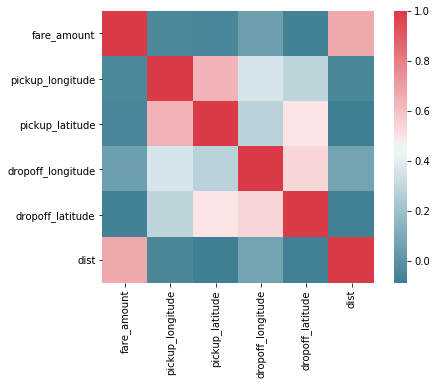

In [42]:
#Set the width and hieght of the plot
f, ax = plt.subplots(figsize=(7, 5))

#Generate correlation matrix
corr = Train_Data_corr.corr()
print(corr)

#Plotted using seaborn library
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [43]:
#eliminate all data with the pickup and drop location points as same

Train_Data=Train_Data[np.logical_and(Train_Data['pickup_longitude'] != Train_Data['dropoff_longitude'],
                                     Train_Data['pickup_latitude'] != Train_Data['dropoff_latitude'])]

In [44]:
# Model Development

In [56]:
# Decision Tree

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor


In [58]:
train1, test1 = train_test_split(Train_Data, test_size=0.2)


In [60]:
# Decision tree for regression
fit_DT = DecisionTreeRegressor(max_depth=2).fit(train1.iloc[:, 1:7], train1.iloc[:,0])

In [61]:
fit_DT

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [64]:
#Apply model on test data
predictions_DT = fit_DT.predict(test1.iloc[:,1:7])

In [66]:
#Calculate MAPE
def MAPE(y_true, y_pred): 
    mape = np.mean(np.abs((y_true - y_pred) / y_true))*100
    return mape

In [67]:
MAPE(test1.iloc[:,0], predictions_DT)


28.819998657938417

In [ ]:
#Error 28.774663291429192
#Accuracy 71.23

In [ ]:
# Random forest

In [68]:
from sklearn.ensemble import RandomForestRegressor

In [69]:
RF_model = RandomForestRegressor(n_estimators = 10).fit(train1.iloc[:, 1:7], train1.iloc[:,0])

In [70]:
RF_model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [71]:
RF_Predictions = RF_model.predict(test1.iloc[:, 1:7])

In [72]:
MAPE(test1.iloc[:,0], RF_Predictions)

25.39246111907223

In [ ]:
#error 25.131668346501414
#accuracy 74.87

In [73]:
#KNN implementation
from sklearn.neighbors import KNeighborsRegressor

KNN_model = KNeighborsRegressor(n_neighbors = 1).fit(train1.iloc[: , 1:7], train1.iloc[:, 0])


In [74]:
#predict test cases
KNN_Predictions = KNN_model.predict(test1.iloc[: , 1:7])


In [75]:
MAPE(test1.iloc[:,0], KNN_Predictions)

34.661843647737186

In [76]:
#error is 34.21410560965663
#accuracy is 65.80

In [ ]:
#Prediction on original test data

In [77]:
pred=(pd.read_csv('test_cab.csv', header = 0 )).drop(columns="pickup_datetime")

In [78]:
#create Dist variable
pred['dist'] = \
    haversine( pred['pickup_latitude'], pred['pickup_longitude'],
                 pred['dropoff_latitude'], pred['dropoff_longitude'])

pred['fare_amount']=0
pred['passenger_count']=pred['passenger_count'].astype('category')

In [79]:
# Build model on the entire Train data
RF_model = RandomForestRegressor(n_estimators = 10).fit(Train_Data.iloc[:, 1:7], Train_Data.iloc[:,0])

#predict value
pred['fare_amount'] = RF_model.predict(pred.iloc[:, 0:6])

In [80]:
pred.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist,fare_amount
0,-73.973320,40.763805,-73.981430,40.743835,1,2.323259,10.64
1,-73.986862,40.719383,-73.998886,40.739201,1,2.425353,9.09
2,-73.982524,40.751260,-73.979654,40.746139,1,0.618628,5.35
3,-73.981160,40.767807,-73.990448,40.751635,1,1.961033,9.32
4,-73.966046,40.789775,-73.988565,40.744427,1,5.387301,14.36


In [81]:
#write output to csv

pred.to_csv("Predicted_Values.csv", index = False)